# Betweeness Centrality

LAGraph_bc: Brandes' algorithm for computing betweeness centrality.
Contributed by Scott Kolodziej and Tim Davis, Texas A&M University.
Adapted from GraphBLAS C API Spec, Appendix B.3.



In [4]:
from pygraphblas import Matrix, Vector, fp64, int8, times, Accum
from pygraphblas.descriptor import oocr
from pygraphblas.demo.gviz import draw


In [14]:
def bc(A, source):
    n = A.nrows
    centrality = Vector.dense(fp64, n, 0)
    S = Matrix.from_type(int, n, n)
    frontier = Vector.from_type(int, n)
    frontier[source] = 1
    paths = Vector.dup(frontier)
    depth = 0
    sum = 0
    while True:
        S[:,depth] = frontier
        frontier = frontier.vxm(A, mask=paths, desc=oocr)
        paths = paths + frontier
        if frontier.reduce_int() == 0:
            break
        depth += 1
    for i in range(depth, 1, -1):
        centrality += S.transpose()[i-1,:] * ((A @ Vector.dense(int, n)) + (centrality / S.transpose()[i,:]))
    return centrality

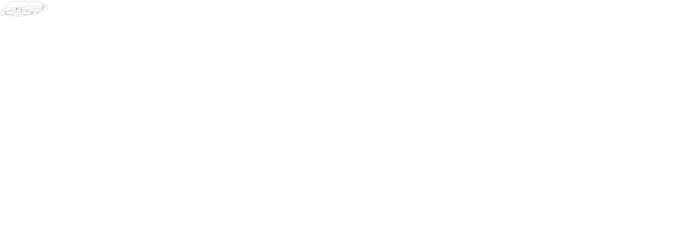

In [15]:
M = Matrix.from_random(int8, 5, 5, 25, no_diagonal=True, make_pattern=True, seed=42)
draw(M, label_vector=bc(M, 2))